# Udacity Machine Learning Capstone

## Requirements

In [0]:
!pip install keras-bert

import os
import subprocess

cmd_download = "wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip"
cmd_unzip = "unzip -o uncased_L-12_H-768_A-12.zip"
if not os.path.isdir('uncased_L-12_H-768_A-12'):
    for cmd in [cmd_download, cmd_unzip]:
        subprocess.call(cmd.split())

!ls -a

.		   sample_data	  uncased_L-12_H-768_A-12
..		   SVM_preds.tsv  uncased_L-12_H-768_A-12.zip
accuracy_drug.png  test.tsv	  validation.tsv
.config		   train.tsv


## Data

Paths of the pretrained BERT model

In [0]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

Upload the data if the notebook is running on Google Colab.

* train.tsv
* validation.tsv
* test.tsv
* SVM_preds.tsv

In [0]:
# from google.colab import files

# if not all(os.path.isfile(div + '.tsv')
#            for div in ['train', 'validation', 'test', 'SVM_preds']):
#     uploaded = files.upload()
    
!ls -a

.		   sample_data	  uncased_L-12_H-768_A-12
..		   SVM_preds.tsv  uncased_L-12_H-768_A-12.zip
accuracy_drug.png  test.tsv	  validation.tsv
.config		   train.tsv


Load data as data frames

In [0]:
import re
import pandas as pd

COLUMNS = ['tweet_id', 'user_id', 'drug', 'label', 'text']
USER_NAME = ' _USERNAME_ '

def preprocess_text(text):
    text = text.strip().lower();
    # Mask user names
    text = re.sub(r'(?<!\w)@[a-z0-9_]+', USER_NAME, text)
    return text

def load_data(file_name):
    df = pd.read_csv(file_name,
                     delimiter='\t',
                     header=None,
                     names=COLUMNS,
                     encoding='utf-8',
                     dtype=str)
    df['text'] = df['text'].apply(preprocess_text)
    df['label'] = df['label'].apply(lambda x: 'acmu'.index(x))
    return df

df_train = load_data('train.tsv')
df_validation = load_data('validation.tsv')
df_test = load_data('test.tsv')
df_train.head()

,tweet_id,user_id,drug,label,text
0,463042844853567488,835854780,adderall,2,and on the third day adderall fell from heaven...
1,867553609990508544,774643936245809152,valium,2,_USERNAME_ ben carson is a fool . he always ...
2,964871777972342785,229518077,xanax,2,_USERNAME_ do they have a physician? many wi...
3,991607217764872192,2706714718,tramadol,1,_USERNAME_ _USERNAME_ _USERNAME_ can you...
4,1008921524210950145,1799069095,adderall,0,🌚🌚🌚 be real and sell me some adderall thx for ...


Description of text lengths

In [0]:
import numpy as np
from scipy.stats import describe

lengths = [
    len(re.sub(r'\W+', ' ', text).split())
    for text in df_train['text']
]
print(describe(lengths))
print('median length:', np.median(lengths))

DescribeResult(nobs=11472, minmax=(1, 109), mean=18.73274058577406, variance=149.79780164205243, skewness=1.828474250439206, kurtosis=5.474870858640367)
median length: 16.0


### Descriptive statistics

In [0]:
from tabulate import tabulate

divs_df = [df_train, df_validation, df_test]

header = ['Division', 'a', 'c', 'm', 'u', 'Total']
counts = [
    [sum(df['label'] == l) for l in range(4)]
    for df in divs_df
]
table = [
    [div] + cnts + [df.shape[0]]
    for div, cnts, df in zip(
        ['Train', 'Validation', 'Test'],
        counts,
        divs_df
    )
]

print(tabulate(table, headers=header))

Division       a     c     m    u    Total
----------  ----  ----  ----  ---  -------
Train       1869  3214  5914  475    11472
Validation   260   449   874   53     1636
Test         503   919  1722  127     3271


Plot of the counts

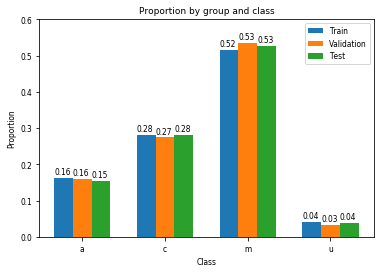

In [0]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 7.5})

ann_labels = list('acmu')
proportion = [
    [cnt / df.shape[0] for cnt in div]
    for div, df in zip(counts, divs_df)
]

width = 0.34
x = np.arange(len(ann_labels)) * 1.5
x_cur = x - width
fig, ax = plt.subplots()

for prop, group in zip(proportion, ['Train', 'Validation', 'Test']):
    rects = ax.bar(x_cur, prop, width, label=group)
    for p, r in zip(prop, rects):
        ax.annotate('{0:.2f}'.format(p),
                    xy=(r.get_x(), r.get_height() + 0.01),)
    x_cur += width

ax.set_ylim((0.0, 0.6))
ax.set_title('Proportion by group and class')
ax.set_xlabel('Class')
ax.set_ylabel('Proportion')
ax.set_xticks(x)
ax.set_xticklabels(ann_labels)
ax.legend()

            
# # Download the plot from Google Colab.
# # May randomly throw an error if run in Firefox.
# plt.savefig('proportion.png', format='png', dpi=300)
# files.download('proportion.png')


## Implementing the classifier

In [0]:
import keras
from keras_bert import get_base_dict, load_trained_model_from_checkpoint

Using TensorFlow backend.


Load the vocabulary of the pretrained BERT model

In [0]:
token_dict = {}
with open(vocab_path, 'r', encoding='utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

token_list = list(token_dict.keys())

Load the pretrained model

In [0]:
SEQ_LEN = 100

model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,
)

W0806 19:12:01.612135 140556937099136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 19:12:01.637861 140556937099136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 19:12:01.698252 140556937099136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 19:12:01.699400 140556937099136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0806 19:12:01.713504

The function performing one-hot-encoding

In [0]:
def to_one_hot(input_labels, range_labels=4):
    num_rows = len(input_labels)
    ohe = np.zeros((num_rows, range_labels))
    ohe[np.arange(num_rows), input_labels] = 1
    return ohe

In [0]:
from keras_bert import Tokenizer

tokenizer = Tokenizer(token_dict)
BATCH_SIZE = 32

A small perturbation in training data for testing the robustness of the model. 10% is removed

In [0]:
# df_train = df_train.sample(frac=0.9,
#                            replace=False,
#                            random_state=42)

Prepare training, validation and testing data.

In [0]:
def gen_clf_data(df):
    indices = []
    for text in df['text']:
        ids, _ = tokenizer.encode(text, max_len=SEQ_LEN)
        indices.append(ids)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], to_one_hot(df['label'])

train_x, train_y = gen_clf_data(df_train)
validation_x, validation_y = gen_clf_data(df_validation)
test_x, test_y = gen_clf_data(df_test)

In [0]:
from keras import layers, regularizers
from keras_bert import AdamWarmup, calc_train_steps

inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
# dense = layers.Lambda(lambda x: keras.backend.expand_dims(x, -1))(dense)
# dense = layers.Conv1D(16, 5, activation='relu')(dense)
# dense = layers.MaxPooling1D(pool_size=4)(dense)
# dense = layers.Flatten()(dense)
# print(dense.shape)
# dense = layers.Dense(units=32,
#                      activation='relu',
#                      kernel_regularizer=regularizers.l2(0.003),
#                      activity_regularizer=regularizers.l1(0.005))(dense)
# dense = layers.BatchNormalization()(dense)
dense = layers.Dropout(0.1)(dense)
outputs = layers.Dense(units=4, activation='softmax')(dense)

EPOCHS = 3

decay_steps, warmup_steps = calc_train_steps(
    train_y.shape[0],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

clf = keras.models.Model(inputs, outputs)

clf.compile(AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=1e-4),
            'categorical_crossentropy',
            metrics=['accuracy'])

# clf.summary()

W0806 19:12:27.996558 140556937099136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
history = clf.fit(train_x,
                  train_y,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_data=(validation_x, validation_y))

W0806 19:12:28.182914 140556937099136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11472 samples, validate on 1636 samples
Epoch 1/3
11472/11472 [==============================] - 529s 46ms/step - loss: 0.7686 - acc: 0.6867 - val_loss: 0.5599 - val_acc: 0.7726
Epoch 2/3
11472/11472 [==============================] - 513s 45ms/step - loss: 0.3798 - acc: 0.8555 - val_loss: 0.5505 - val_acc: 0.7897
Epoch 3/3
11472/11472 [==============================] - 513s 45ms/step - loss: 0.1147 - acc: 0.9619 - val_loss: 0.7059 - val_acc: 0.7903


### Visualization of training / validation loss

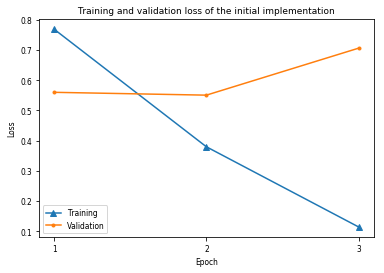

In [0]:
fig, ax = plt.subplots()

epoch_x = np.arange(1, 4)

ax.plot(epoch_x, history.history['loss'], marker='^', label='Training')
ax.plot(epoch_x, history.history['val_loss'], marker='.', label='Validation')

ax.set_xticks(epoch_x)
ax.set_xticklabels(epoch_x)
ax.set_title('Training and validation loss of the initial implementation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# plt.savefig('loss.png', format='png', dpi=300)
# files.download('loss.png')

## Testing the trained classifier

In [0]:
df_test = df_test.assign(pred=np.argmax(clf.predict(test_x), axis=1))

In [0]:
from pprint import pprint
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

scores_test = precision_recall_fscore_support(df_test['label'],
                                              df_test['pred'])
pprint(scores_test)
print(accuracy_score(df_test['label'], df_test['pred']))

(array([0.608     , 0.75599583, 0.8620283 , 0.9137931 ]),
 array([0.60437376, 0.78890098, 0.84901278, 0.83464567]),
 array([0.60618146, 0.77209798, 0.85547104, 0.87242798]),
 array([ 503,  919, 1722,  127]))
0.7939468052583308


## Comparison with the benchmark model

In [0]:
df_benchmark = pd.read_csv('SVM_preds.tsv',
                           sep='\t',
                           header=None,
                           names=['tweet_id', 'pred'],
                           dtype=str)
df_benchmark['pred'] = df_benchmark['pred'].apply(lambda x: 'acmu'.index(x))

Sort the test data by tweet id, to facilitate the comparison with the benchmark model

In [0]:
for df in [df_test, df_benchmark]:
    df.sort_values(by=['tweet_id'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
msg = "Non-identical list of samples"
assert all(df_test['tweet_id'] == df_benchmark['tweet_id']), msg

In [0]:
scores_benchmark = precision_recall_fscore_support(df_test['label'],
                                                   df_benchmark['pred'])
pprint(scores_benchmark)
print(accuracy_score(df_test['label'], df_benchmark['pred']))

(array([0.46615385, 0.76560333, 0.80616246, 0.8173913 ]),
 array([0.60238569, 0.60065288, 0.83565621, 0.74015748]),
 array([0.52558543, 0.67317073, 0.82064443, 0.7768595 ]),
 array([ 503,  919, 1722,  127]))
0.7300519718740446


### Plot of the test scores

Text(0.5, 0.98, 'Test scores of BERT vs. Benchmark')

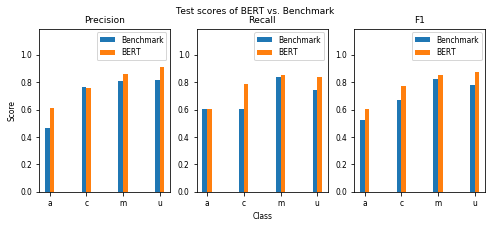

In [0]:
width = 0.1
x = np.arange(len(ann_labels)) * 0.8
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

score_names = ['Precision', 'Recall', 'F1']

for i in range(3):
    x_cur = x - 0.5 * width
    for scores, group in zip([scores_benchmark[i], scores_test[i]],
                             ['Benchmark', 'BERT']):
        rects = axs[i].bar(x_cur, scores, width, label=group)
        x_cur += width

    axs[i].set_ylim((0.0, 1.19))
    axs[i].set_title(score_names[i])
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(ann_labels)
    axs[i].legend()

axs[1].set_xlabel('Class')
axs[0].set_ylabel('Score')
fig.suptitle('Test scores of BERT vs. Benchmark')

# plt.savefig('comp_scores.png', format='png', dpi=300)
# files.download('comp_scores.png')

## Significance of difference between the BERT-based model and the benchmark model

McNemar’s Test

In [0]:
from statsmodels.stats.contingency_tables import mcnemar

table = [[0, 0], [0, 0]]

for i in range(df_test.shape[0]):
    row = int(df_test['pred'][i] == df_test['label'][i])
    column = int(df_benchmark['pred'][i] == df_test['label'][i])
    table[row][column] += 1
    
pprint(table)
print(mcnemar(table, exact=True))

[[430, 244], [453, 2144]]
pvalue      2.05429675800884e-15
statistic   244.0


## Free-form visualization

Accuracy by drug (with count of mention >= 70).

Text(0.5, 1.0, 'Prediction accuracy by drug')

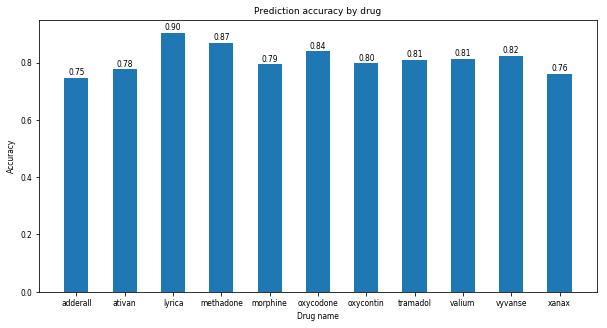

In [0]:
from collections import Counter

cnt_by_drug = Counter(df_test['drug'])
cnt_correct_by_drug = Counter(
    row['drug'] for _, row in df_test.iterrows()
    if row['pred'] == row['label']
)
acc_by_drug = {
    drug: cnt_correct_by_drug[drug] / cnt_by_drug[drug]
    for drug, n in cnt_by_drug.items() if n >= 70
}

width = 0.5
x = np.arange(len(acc_by_drug)) * 3
drug_labels = sorted(acc_by_drug)
accs = [acc_by_drug[drug] for drug in drug_labels]
fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(drug_labels, accs, width=width)
for acc, rec in zip(accs, rects):
    ax.annotate('{0:.2f}'.format(acc),
                xy=(rec.get_x() + 0.08, rec.get_height() + 0.01),)

ax.set_xlabel('Drug name')
ax.set_ylabel('Accuracy')
ax.set_title('Prediction accuracy by drug')

# plt.savefig('accuracy_drug.png', format='png', dpi=300)
# files.download('accuracy_drug.png')